Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Small_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_small-0c510722.pth" to /root/.cache/torch/hub/checkpoints/convnext_small-0c510722.pth
100%|██████████| 192M/192M [00:00<00:00, 206MB/s] 
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning

Epoch 1/9:
Train Loss: 0.6556, Train Accuracy: 0.6749
Val Loss: 0.4865, Val Accuracy: 0.7569
Epoch 2/9:
Train Loss: 0.3759, Train Accuracy: 0.8277
Val Loss: 0.2356, Val Accuracy: 0.9167
Epoch 3/9:
Train Loss: 0.2351, Train Accuracy: 0.8997
Val Loss: 0.3060, Val Accuracy: 0.8819
Epoch 4/9:
Train Loss: 0.1645, Train Accuracy: 0.9336
Val Loss: 0.0942, Val Accuracy: 0.9583
Epoch 5/9:
Train Loss: 0.1430, Train Accuracy: 0.9444
Val Loss: 0.0505, Val Accuracy: 0.9861
Epoch 6/9:
Train Loss: 0.0850, Train Accuracy: 0.9688
Val Loss: 0.1062, Val Accuracy: 0.9583
Epoch 7/9:
Train Loss: 0.0979, Train Accuracy: 0.9627
Val Loss: 0.0577, Val Accuracy: 0.9792
Epoch 8/9:
Train Loss: 0.0718, Train Accuracy: 0.9735
Val Loss: 0.0352, Val Accuracy: 0.9896
Epoch 9/9:
Train Loss: 0.0441, Train Accuracy: 0.9831
Val Loss: 0.0364, Val Accuracy: 0.9861
✅ Training complete.

📊 **Test Set Performance**
✅ Accuracy: 0.9722
✅ Precision: 0.9730
✅ Recall: 0.9722
✅ F1-score: 0.9723
✅ ROC AUC Score: 0.9977

📌 **Class-wise

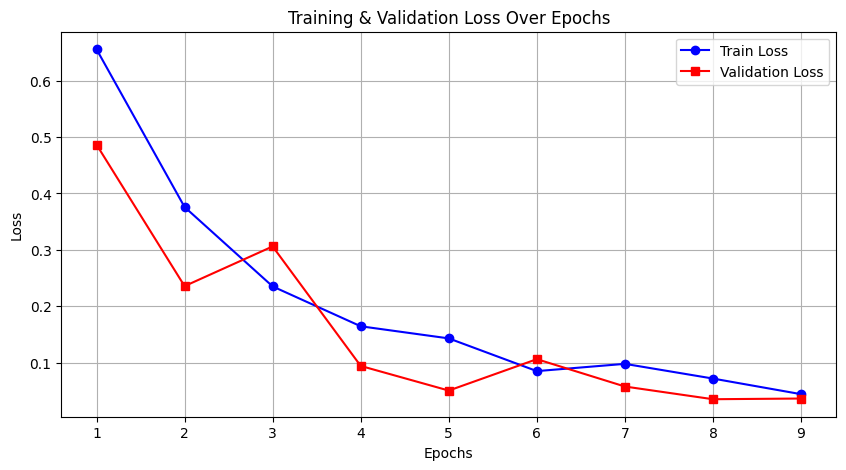

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import os

# 🚀 Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 📂 Dataset path
data_dir = "/kaggle/input/lung-cancer-dataset1"

# ✅ Fixed Normalization (ImageNet)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 📂 Load datasets
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=train_transform)
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "val"), transform=val_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "test"), transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

# 🚀 Load ConvNeXt-Small
model = models.convnext_small(pretrained=True)
num_ftrs = model.classifier[2].in_features
model.classifier[2] = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(num_ftrs, len(train_dataset.classes))
)
model = model.to(device)

# 🔥 Weighted Loss
class_counts = np.bincount([label for _, label in train_dataset.samples])
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

# 🏋️ Training
num_epochs = 9
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_preds, train_labels = [], []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_losses.append(train_loss / len(train_loader))
    train_acc = accuracy_score(train_labels, train_preds)
    train_accuracies.append(train_acc)

    # 🚀 Validation
    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []
    val_probs = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_probs.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())
            val_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    val_acc = accuracy_score(val_labels, val_preds)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_acc:.4f}")
    scheduler.step(val_loss)

print("✅ Training complete.")

# ✅ Evaluate on Test Set
model.eval()
test_preds, test_labels, test_probs = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_probs.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())
        test_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# 📊 Test Metrics
test_acc = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
test_recall = recall_score(test_labels, test_preds, average='weighted', zero_division=0)
test_f1 = f1_score(test_labels, test_preds, average='weighted', zero_division=0)
test_auc = roc_auc_score(test_labels, test_probs, multi_class='ovr')

print("\n📊 **Test Set Performance**")
print(f"✅ Accuracy: {test_acc:.4f}")
print(f"✅ Precision: {test_precision:.4f}")
print(f"✅ Recall: {test_recall:.4f}")
print(f"✅ F1-score: {test_f1:.4f}")
print(f"✅ ROC AUC Score: {test_auc:.4f}")

# 📌 Class-wise Accuracy on Test Set
test_class_correct = {class_name: 0 for class_name in test_dataset.classes}
test_class_total = {class_name: 0 for class_name in test_dataset.classes}

for label, pred in zip(test_labels, test_preds):
    class_name = test_dataset.classes[label]
    test_class_total[class_name] += 1
    if label == pred:
        test_class_correct[class_name] += 1

print("\n📌 **Class-wise Accuracy (Test Dataset)**")
for class_name in test_dataset.classes:
    accuracy = 100 * test_class_correct[class_name] / test_class_total[class_name]
    print(f"✅ {class_name}: {accuracy:.2f}%")

# 📈 Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", color='blue', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", color='red', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


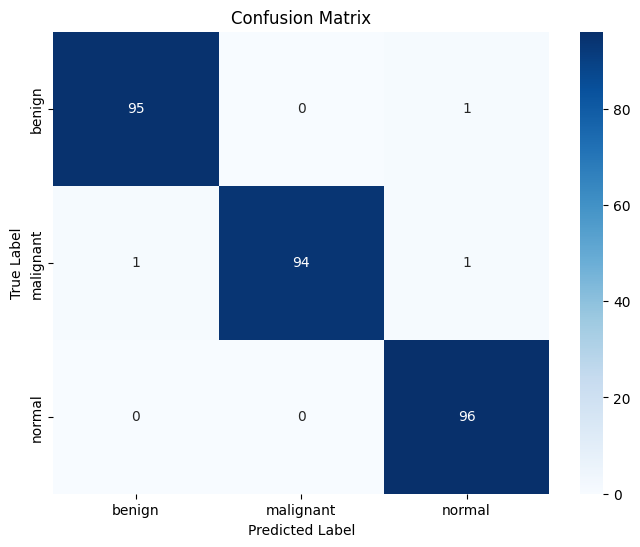

In [2]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 📊 Compute Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)

# 🎨 Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

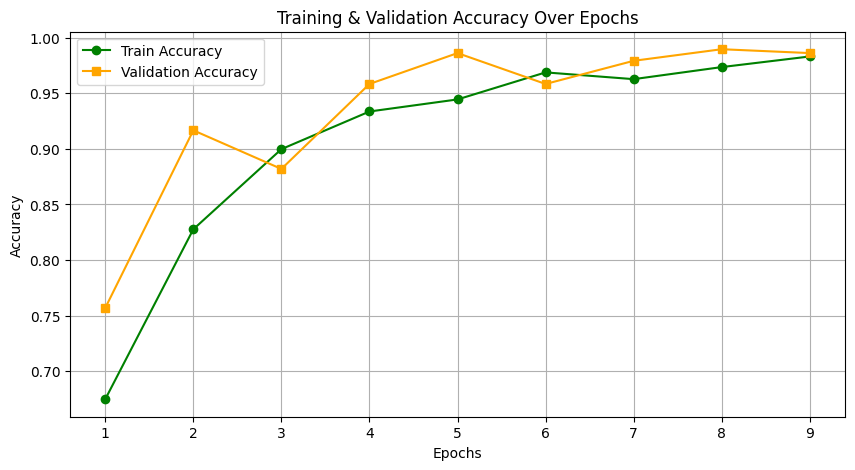

In [3]:
# 📈 Plot Accuracy Curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy", color='green', marker='o')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy", color='orange', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


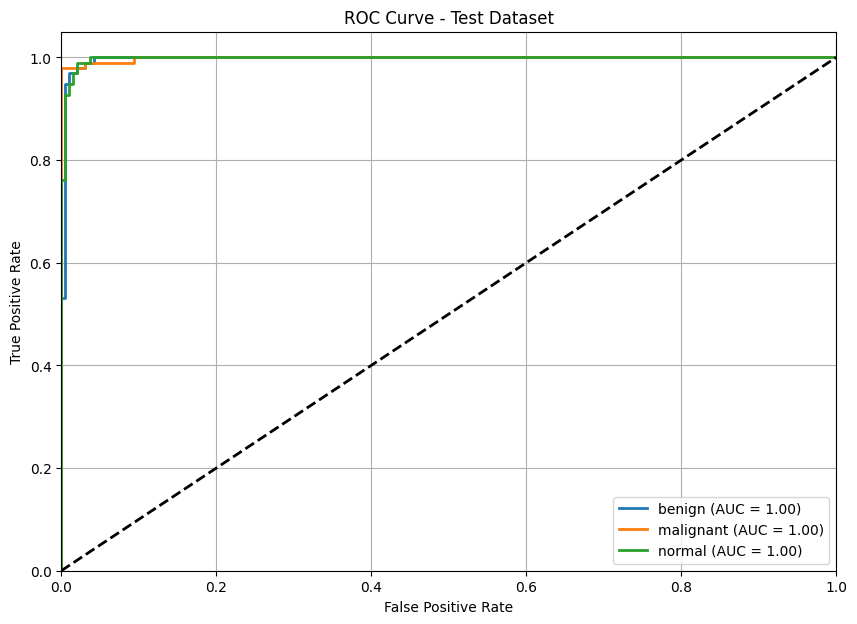

In [4]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# 🎯 Binarize true labels
n_classes = len(test_dataset.classes)
test_labels_bin = label_binarize(test_labels, classes=list(range(n_classes)))
test_probs = np.array(test_probs)

# 🎯 Compute ROC Curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 📉 Plot ROC curves
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{test_dataset.classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test Dataset")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
